In [ ]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import random
from copy import deepcopy
import gymnasium as gym

import os

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time

In [5]:
def eval_agent(agent, env, n_sim=5):
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done:
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum
    return episode_rewards


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, reward, terminated, next_state):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.choices(self.memory, k=batch_size)

    def __len__(self):
        return len(self.memory)


class Net(nn.Module):

    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        # return self.net(x)
        x = x.view(x.size(0), -1)
        return self.net(x)


class DQN:
    def __init__(
        self,
        env,
        action_space,
        observation_space,
        gamma,
        batch_size,
        buffer_capacity,
        update_target_every,
        epsilon_start,
        decrease_epsilon_factor,
        epsilon_min,
        learning_rate,
    ):
        self.env = env
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = (
            decrease_epsilon_factor
        )
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate

        self.reset()

    def update(self, state, action, reward, terminated, next_state):
        # Convert numpy arrays or lists to tensors and ensure they are floats
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        action_tensor = torch.tensor([[action]], dtype=torch.int64)
        reward_tensor = torch.tensor([reward], dtype=torch.float32)
        terminated_tensor = torch.tensor([terminated], dtype=torch.float32)

        # Store transition in the replay buffer
        self.buffer.push(
            state_tensor,
            action_tensor,
            reward_tensor,
            terminated_tensor,
            next_state_tensor,
        )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batch
        transitions = self.buffer.sample(self.batch_size)

        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = (
            tuple([torch.cat(data) for data in zip(*transitions)])
        )

        values = self.q_net.forward(state_batch).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(
                next_state_batch
            ).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model with gradient clipping
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1)  # Gradient clipping
        self.optimizer.step()

        # Soft update the target network
        for target_param, local_param in zip(
            self.target_net.parameters(), self.q_net.parameters()
        ):
            target_param.data.copy_(
                0.995 * target_param.data + 0.005 * local_param.data
            )

        self.scheduler.step()  # Step through the scheduler

        if not ((self.n_steps + 1) % self.update_target_every):
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.decrease_epsilon()

        self.n_steps += 1
        if terminated:
            self.n_eps += 1

        return loss.detach().numpy()

    def get_action(self, state, epsilon=None):
        """
        Return action according to an epsilon-greedy exploration policy
        """
        if epsilon is None:
            epsilon = self.epsilon

        if np.random.rand() < epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.get_q(state))

    def get_q(self, state):
        """
        Compute Q function for a states
        """
        state_tensor = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        with torch.no_grad():
            output = self.q_net.forward(state_tensor)  # shape (1,  n_actions)
        return output.numpy()[0]  # shape  (n_actions)

    def decrease_epsilon(self):
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
            np.exp(-1.0 * self.n_eps / self.decrease_epsilon_factor)
        )

    def reset(self):
        hidden_size = 256

        obs_size = np.prod(self.env.observation_space.shape)
        n_actions = self.action_space.n

        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net = Net(obs_size, hidden_size, n_actions)
        self.target_net = Net(obs_size, hidden_size, n_actions)
        self.target_net.load_state_dict(
            self.q_net.state_dict()
        )  # Initialize target net
        self.target_net.eval()  # Set target net to eval mode

        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(
            params=self.q_net.parameters(), lr=self.learning_rate, weight_decay=1e-5
        )
        self.scheduler = StepLR(
            self.optimizer, step_size=100, gamma=0.99
        )  # Learning rate scheduler

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0

    def save(self, filename):
        """
        Save the current model parameters to the specified file.
        """
        torch.save(
            {
                "q_net_state_dict": self.q_net.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "scheduler_state_dict": self.scheduler.state_dict(),
                "epsilon": self.epsilon,
                "n_steps": self.n_steps,
                "n_eps": self.n_eps,
            },
            filename,
        )
        print(f"Model saved to {filename}")

    def load(self, filename):
        """
        Load model parameters from the specified file.
        """
        checkpoint = torch.load(filename)
        self.q_net.load_state_dict(checkpoint["q_net_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
        self.epsilon = checkpoint["epsilon"]
        self.n_steps = checkpoint["n_steps"]
        self.n_eps = checkpoint["n_eps"]
        self.target_net.load_state_dict(self.q_net.state_dict())
        print(f"Model loaded from {filename}")


def run_one_episode(env, agent, display=True):
    display_env = deepcopy(env)
    done = False
    state, _ = display_env.reset()

    rewards = 0

    while not done or truncated:
        action = agent.get_action(state, 0)
        state, reward, done, truncated, info = display_env.step(action)
        rewards += reward
        print(rewards)
        if display:
            clear_output(wait=True)
            plt.imshow(display_env.render())
            plt.show()
    if display:
        display_env.close()
    print(f"Episode length {rewards}")

In [6]:
def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    total_time = 0
    state, _ = env.reset()
    losses = []
    mean_rewards = []
    epsilon = []
    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()
        while not done:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            loss_val = agent.update(state, action, reward, terminated, next_state)

            state = next_state
            losses.append(loss_val)

            done = terminated or truncated
            total_time += 1

        if (ep + 1) % eval_every == 0:
            rewards = eval_agent(agent, env)
            print("episode =", ep + 1, ", reward = ", np.mean(rewards), "epsilon =", agent.epsilon)
            mean_rewards.append(np.mean(rewards))
            epsilon.append(agent.epsilon)
            if (ep + 1) in [10, 50, 100, 300, 500, 750, 1000, 2000, 3000, 4000, 5000]:
              name = "highway_fast_dqn_" + str(ep+1) + ".pth"
              path = "" + name
              agent.save(path)
            if np.mean(rewards) >= reward_threshold:
                break

    return losses, mean_rewards, epsilon

In [7]:
config = {
    "observation": {
        "type": "OccupancyGrid",
        "vehicles_count": 10,
        "features": ["presence", "x", "y", "vx", "vy", "cos_h", "sin_h"],
        "features_range": {
            "x": [-100, 100],
            "y": [-100, 100],
            "vx": [-20, 20],
            "vy": [-20, 20],
        },
        "grid_size": [[-20, 20], [-20, 20]],
        "grid_step": [5, 5],
        "absolute": False,
    },
    "action": {
        "type": "DiscreteAction",
    },
    "lanes_count": 3,
    "vehicles_count": 10,
    "duration": 20,  # [s]
    "initial_spacing": 0,
    "collision_reward": -1,  # The reward received when colliding with a vehicle.
    "right_lane_reward": 0.5,  # The reward received when driving on the right-most lanes, linearly mapped to
    # zero for other lanes.
    "high_speed_reward": 0.1,  # The reward received when driving at full speed, linearly mapped to zero for
    # lower speeds according to config["reward_speed_range"].
    "lane_change_reward": 0,
    "reward_speed_range": [
        20,
        30,
    ],  # [m/s] The reward for high speed is mapped linearly from this range to [0, HighwayEnv.HIGH_SPEED_REWARD].
    "simulation_frequency": 5,  # [Hz]
    "policy_frequency": 1,  # [Hz]
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "screen_width": 600,  # [px]
    "screen_height": 150,  # [px]
    "centering_position": [0.3, 0.5],
    "scaling": 5.5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False,
    "disable_collision_checks": True,
}


In [13]:
# Adjusted environment initialization for "highway-fast-v0"
import gymnasium as gym
from gymnasium import spaces

# Configure and create the environment
env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)
action_space = env.action_space
observation_space = env.observation_space

gamma = 0.8
batch_size = 128
buffer_capacity = 20000
update_target_every = 32
epsilon_start = 0.9
decrease_epsilon_factor = 200
epsilon_min = 0.01
learning_rate = 1e-3

hidden_size = 256
n_actions = env.action_space.n

In [ ]:
# instantiate the DQN agent:
agent = DQN(
    env,
    action_space,
    observation_space,
    gamma,
    batch_size,
    buffer_capacity,
    update_target_every,
    epsilon_start,
    decrease_epsilon_factor,
    epsilon_min,
    learning_rate,
)

N_episodes = 5000

losses, rewards, epsilon = train(env, agent, N_episodes)
# agent.save("mydrive/MyDrive/RL/dqn_agent_4_10000.pth")

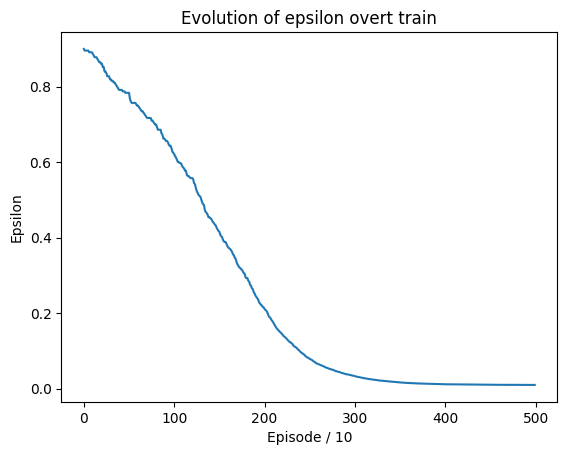

In [ ]:
plt.plot(epsilon)
plt.title('Evolution of epsilon overt train')
plt.xlabel('Episode / 10')
plt.ylabel('Epsilon')
plt.show()

In [24]:
# Load the trained agent
agent = DQN(env, action_space, observation_space, gamma, batch_size, buffer_capacity, update_target_every, epsilon_start, decrease_epsilon_factor, epsilon_min, learning_rate)
agent.load("highway_fast_dqn_5000.pth")

Model loaded from mydrive/MyDrive/RL/dqn_agent_4_5000.pth


In [32]:
env = gym.make("highway-fast-v0", render_mode="rgb_array", config=config)

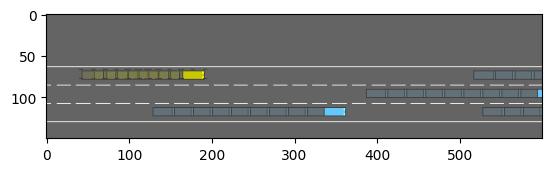

72.25874999999996


KeyboardInterrupt: 

In [33]:
run_one_episode(env, agent, display=True)